In [1]:
import sys
sys.path.append("/work/multi_doc_analyzer")
sys.path.append("/work/relation_extraction/Bert_model/bert_dep/data/")

import torch as T
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.cuda
from allennlp.nn import util as nn_util
from multi_doc_analyzer.structure.structure import *
from multi_doc_analyzer.tokenization.tokenizer import MDATokenizer
from tqdm import tqdm

from allennlp.data.dataset_readers import DatasetReader
from allennlp.data.tokenizers import Token, Tokenizer, WordTokenizer
from allennlp.data.token_indexers import TokenIndexer

from allennlp.data.instance import Instance
from allennlp.data.fields import TextField, LabelField, ArrayField

from tacred_preprocess import DataLoader

from allennlp.data.vocabulary import Vocabulary
from allennlp.data.iterators import BucketIterator, DataIterator, BasicIterator
from allennlp.nn.util import get_text_field_mask
from allennlp.models import Model
from allennlp.modules.text_field_embedders import TextFieldEmbedder
import random

from allennlp.data.token_indexers import PretrainedBertIndexer
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.modules.token_embedders.bert_token_embedder import PretrainedBertEmbedder

from sklearn.metrics import precision_recall_fscore_support as prs 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import csv

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [2]:
sys.path.append("/work/multi-relation-extraction/")
from evaluate import compute_macro_PRF

In [3]:
train_path = "/work/tacred/data/json/train.json"
test_path = "/work/tacred/data/json/test.json"
model_folder = "/work/model_checkpoint/bert_model_checkpoint/bert_dep/tacred"
output_path = "/work/relation_extraction/Bert_model/bert_dep/analysis/tacred/"

In [4]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)
        
config = Config(
    seed=1,
    batch_size=10,
    lr=3e-4,                # learning rate
    epochs=50,
    hidden_sz=128,
    arg_sz=30,
    dep_sz=30,
    max_seq_len=400
)

In [5]:
USE_GPU = T.cuda.is_available()
USE_GPU

True

In [6]:
# set seed for both CPU and CUDA
T.manual_seed(config.seed)

In [7]:
# from ace05_set_reader import ACE05Reader
# train_path = "/work/LDC2006T06/dataset/train/"
# reader = ACE05Reader(lang='en')
# doc_dicts = reader.read(train_path)
# tokenizer = MDATokenizer('bert-en')
# for doc in doc_dicts.values():
#     tokenizer.annotate_document(doc)
#     for s in doc.sentences: 
        

In [8]:
e_label2idx = {'X': 0, 'O': 1, 'PERSON': 2, 'ORGANIZATION': 3, 'DATE': 4, 'NUMBER': 5, 'TITLE': 6, 'COUNTRY': 7, 'LOCATION': 8, 'CITY': 9, 'MISC': 10, 'STATE_OR_PROVINCE': 11, 'DURATION': 12, 'NATIONALITY': 13, 'CAUSE_OF_DEATH': 14, 'CRIMINAL_CHARGE': 15, 'RELIGION': 16, 'URL': 17, 'IDEOLOGY': 18}

r_label2idx = {'no_relation': 0, 'per:title': 1, 'org:top_members/employees': 2, 'per:employee_of': 3, 'org:alternate_names': 4, 'org:country_of_headquarters': 5, 'per:countries_of_residence': 6, 'org:city_of_headquarters': 7, 'per:cities_of_residence': 8, 'per:age': 9, 'per:stateorprovinces_of_residence': 10, 'per:origin': 11, 'org:subsidiaries': 12, 'org:parents': 13, 'per:spouse': 14, 'org:stateorprovince_of_headquarters': 15, 'per:children': 16, 'per:other_family': 17, 'per:alternate_names': 18, 'org:members': 19, 'per:siblings': 20, 'per:schools_attended': 21, 'per:parents': 22, 'per:date_of_death': 23, 'org:member_of': 24, 'org:founded_by': 25, 'org:website': 26, 'per:cause_of_death': 27, 'org:political/religious_affiliation': 28, 'org:founded': 29, 'per:city_of_death': 30, 'org:shareholders': 31, 'org:number_of_employees/members': 32, 'per:date_of_birth': 33, 'per:city_of_birth': 34, 'per:charges': 35, 'per:stateorprovince_of_death': 36, 'per:religion': 37, 'per:stateorprovince_of_birth': 38, 'per:country_of_birth': 39, 'org:dissolved': 40, 'per:country_of_death': 41}

d_label2idx = {"PAD": 0, "UNK": 1, 'punct': 2, 'compound': 3, 'case': 4, 'nmod': 5, 'det': 6, 'nsubj': 7, 'amod': 8, 'conj': 9, 'dobj': 10, 'ROOT': 11, 'cc': 12, 'nmod:poss': 13, 'mark': 14, 'advmod': 15, 'appos': 16, 'nummod': 17, 'dep': 18, 'ccomp': 19, 'aux': 20, 'advcl': 21, 'acl:relcl': 22, 'xcomp': 23, 'cop': 24, 'acl': 25, 'auxpass': 26, 'nsubjpass': 27, 'nmod:tmod': 28, 'neg': 29, 'compound:prt': 30, 'mwe': 31, 'parataxis': 32, 'root': 33, 'nmod:npmod': 34, 'expl': 35, 'csubj': 36, 'cc:preconj': 37, 'iobj': 38, 'det:predet': 39, 'discourse': 40, 'csubjpass': 41}
# r_label2idx = {'PHYS': 1, 'PART-WHOLE': 2, 'PER-SOC': 3, 'ORG-AFF': 4, 'ART': 5, 'GEN-AFF': 6, 'NONE': 039

r_idx2label = {v: k for k, v in r_label2idx.items()}

class RelationDatasetReader(DatasetReader):
    """
    Reads Structure object formatted datasets files, and creates AllenNLP instances.
    """
    def __init__(self, tokenizer: Tokenizer=None, token_indexers: Dict[str, TokenIndexer]=None, 
                 MAX_WORDPIECES: int=config.max_seq_len, 
                 is_training = False, reader: DataLoader=None):
        # make sure results may be reproduced when sampling...
        super().__init__(lazy=False)
        random.seed(0)
        self.is_training = is_training
        self.reader = reader
        
        # NOTE AllenNLP automatically adds [CLS] and [SEP] word peices in the begining and end of the context,
        # therefore we need to subtract 2
        self.MAX_WORDPIECES = MAX_WORDPIECES - 2
        
        self.tokenizer = tokenizer or WordTokenizer()
        
        # BERT specific init
        self._token_indexers = token_indexers

    def text_to_instance(self, sentence: Sentence) -> Instance:

        field = {}
        
        # tokens
        sentence_field = TextField(sentence["tokens"], self._token_indexers)
        fields = {"tokens": sentence_field}

#         arg_vec = T.tensor([[0, 0] for i in range(len(sentence.tokens) + 2)], dtype=T.long)   # long type to feed into embedding layer
        arg_vec = T.tensor([0 for i in range(config.max_seq_len)], dtype=T.long)   # long type to feed into embedding layer
        dep_type = T.tensor([0 for i in range(config.max_seq_len)], dtype=T.long)
        
        # dependency type number
        for i in range(sentence["len"]):
            dep_type[i] = sentence["dep_pos"][i]
        fields["dep"] = ArrayField(dep_type)
        
        # position 
        for i in range(sentence["len"]):
            arg_vec[i] = sentence["position"][i]    # arg_l position, i-1 for [CLS]
        fields["arg_idx"] = ArrayField(arg_vec)

        # dependency information
#         dep = T.tensor([[0 for i in range(len(sentence["subj_path"]))] for j in range(2)], dtype=T.float)
#         for i in range(len(sentence["subj_path"])):
#             dep[0][i] = sentence["subj_path"][i]
#             dep[1][i] = sentence["obj_path"][i]
#         fields["dep"] = ArrayField(dep)

        # relation
        if self.is_training:
            fields["label"] = LabelField(sentence["relation"], skip_indexing=True)
        
        return Instance(fields)
    
    def _read(self, file_path: str)->Iterator: 
        sen_list = self.reader.data
        for s in sen_list:
            if s["len"] <= config.max_seq_len:
                yield self.text_to_instance(s)

In [9]:
# ace05_reader = ACE05Reader(lang='en')

# token_indexer = PretrainedBertIndexer(
#     pretrained_model="bert-base-uncased",
# #         max_pieces=config.max_seq_len,
# #         do_lowercase=False               # for cased condition
# )

# # AllenNLP DatasetReader
# reader = RelationDatasetReader(
#     is_training=True, 
#     ace05_reader=ace05_reader, 
#     tokenizer=lambda s: token_indexer.wordpiece_tokenizer(s),
#     token_indexers={"tokens": token_indexer}
# )

# train_ds = reader.read(train_path)

In [10]:
class BERT(Model):
    def __init__(self, word_embeddings: TextFieldEmbedder,
                out_sz: int=len(r_label2idx)):
        super().__init__(vocab)
        self.word_embeddings = word_embeddings
        self._entity_embeddings = T.nn.Embedding(num_embeddings=len(e_label2idx), embedding_dim=config.arg_sz, padding_idx=0)
        self._dep_embeddings = T.nn.Embedding(num_embeddings=len(d_label2idx), embedding_dim=config.dep_sz, padding_idx=0)
        self.gru = T.nn.GRU(word_embeddings.get_output_dim()+config.arg_sz+config.dep_sz, config.hidden_sz, batch_first=True)
        self.projection = nn.Linear(config.hidden_sz, out_sz)
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, tokens: Dict[str, T.tensor], arg_idx: T.tensor, dep: T.tensor, label: T.tensor = None) -> Dict[str, T.tensor]:
        mask = get_text_field_mask(tokens)
        
        embeddings = self.word_embeddings(tokens)
        pad_len = embeddings.shape[-2]

        arg_idx = arg_idx[:,:pad_len]
        arg_idx = arg_idx.type(T.long)
        dep = dep[:, :pad_len]
        dep = dep.type(T.long)
#         print(arg_idx)
        arg_emb = self._entity_embeddings(arg_idx)
        dep_emb = self._dep_embeddings(dep)
        arg_emb = T.cat((arg_emb, dep_emb), -1)
#         print(arg_emb)
        concat = T.cat((embeddings, arg_emb), -1)
        ot, ht = self.gru(concat, None) # revise this "None"
        ot = ot[:,-1,:] 
#         dep_info_ot = T.cat((ot, dep[:, 0, :], dep[:, 1, :]), -1)
        
        class_logits = self.projection(ot)
#         print(vars(label))
        output = {"class_logits": class_logits}
        output["loss"] = self.loss(class_logits, label)

        return output

In [11]:
from scipy.special import expit # the sigmoid function
def tonp(tsr): return tsr.detach().cpu().numpy()

In [12]:
# Predict
class Predictor:
    def __init__(self, model: Model, iterator: DataIterator,
                 cuda_device: int=-1) -> None:
        self.model = model
        self.iterator = iterator
        self.cuda_device = cuda_device
        
    def _extract_data(self, batch) -> np.ndarray:
        out_dict = self.model(**batch)
        return expit(tonp(out_dict["class_logits"]))
    
    def predict(self, ds: Iterable[Instance]) -> np.ndarray:
        pred_generator = self.iterator(ds, num_epochs=1, shuffle=False)
        self.model.eval()
        pred_generator_tqdm = tqdm(pred_generator, total=self.iterator.get_num_batches(ds))
        preds = []
        with T.no_grad():
            for batch in pred_generator_tqdm:
                batch = nn_util.move_to_device(batch, self.cuda_device)
                preds.append(self._extract_data(batch))
        return np.concatenate(preds, axis=0)

In [13]:
def plot_comfusion_matrix(label_classes, predict_classes, out_folder, file_name):
    label_types = list(r_idx2label.values())

    cm = confusion_matrix(label_classes, predict_classes, label_types)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center', color='white')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + label_types)
    ax.set_yticklabels([''] + label_types)
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.savefig(out_folder + 'confusion_matrix_' + file_name + '.png')
    plt.show()

    pre, recall, f1, sup = prs(label_classes, predict_classes, average='macro')
    
    print("Accuracy:", sum(cm[i][i] for i in range(len(cm))) / len(label_classes))
    print("Precision:", pre)
    print("Recall:", recall)
    print("F1 score:", f1)

In [14]:
def err_analyze(ds, true, pred, opt):
    
    # classify different kinds of error
    detail = [[[] for j in range(len(r_label2idx))] for i in range(len(r_label2idx))]
    for i in range(len(ds)):
         if true[i] != pred[i]:
            detail[r_label2idx[true[i]]][r_label2idx[pred[i]]].append(i)
    
    # print into a csv file
    with open(output_path + "error_detail_" + opt + ".csv", "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Sentence", "Two_Entity", "Predict", "Label", "idx"])
        for j in range(len(detail)):
            for k in range(len(detail)):
                with_element = 0
                if k == j:
                    continue
                for i in detail[j][k]:
                    with_element = 1
                    ent1 = []
                    ent2 = []
                    seq = 0
                    prev = 0
                    for g in range(len(vars(ds[i].fields['arg_idx'])['array'])):
                        if int(vars(ds[i].fields['arg_idx'])['array'][g]) != 1 and int(vars(ds[i].fields['arg_idx'])['array'][g]) != 0:
                            if ent1 == [] or (seq == 1 and prev == vars(ds[i].fields['arg_idx'])['array'][g]):
                                prev = vars(ds[i].fields['arg_idx'])['array'][g]
                                seq = 1
                                ent1.append(vars(ds[i].fields['tokens'])['tokens'][g-1])
                            else:
                                seq = 2
                                ent2.append(vars(ds[i].fields['tokens'])['tokens'][g-1])
                        else: 
                            seq = 0
    
                    tostr = lambda a: [str(a[i]) for i in range(len(a))] 
                    writer.writerow([" ".join(tostr(vars(ds[i].fields['tokens'])['tokens'])), [ent1, ent2], pred[i], true[i], i])
                if with_element == 1:
                    writer.writerow("")

In [15]:

if __name__ == '__main__':

    tacred_reader = DataLoader(train_path, e_label2idx, r_label2idx, d_label2idx, config.dep_sz, {"lower": True})
    
    token_indexer = PretrainedBertIndexer(
        pretrained_model="bert-base-uncased",
#         max_pieces=config.max_seq_len,
#         do_lowercase=False               # for cased condition
    )
 
	# AllenNLP DatasetReader
    reader = RelationDatasetReader(
        is_training=True, 
        reader=tacred_reader, 
        tokenizer=lambda s: token_indexer.wordpiece_tokenizer(s),
        token_indexers={"tokens": token_indexer}
    )

    train_ds = reader.read(train_path)
    print(len(train_ds))
#     for e in range(20):
#         print(len(vars(train_ds[e].fields['tokens'])['tokens']))
#         print(vars(train_ds[e].fields['tokens']))
#         print(type(vars(train_ds[0].fields['arg_idx'])['array'][0]))
#         print(vars(train_ds[e].fields['arg_idx']))
#         print(vars(train_ds[e].fields['label']))
    
    vocab = Vocabulary()
    iterator = BucketIterator(batch_size=config.batch_size, sorting_keys=[("tokens", "num_tokens")])
    iterator.index_with(vocab)

    bert_embedder = PretrainedBertEmbedder(
        pretrained_model="bert-base-uncased",
        top_layer_only=True, # conserve memory   
    )
    word_embeddings: TextFieldEmbedder = BasicTextFieldEmbedder({"tokens": bert_embedder},
                                                                # we'll be ignoring masks so we'll need to set this to True
                                                               allow_unmatched_keys = True)
#     print(token_indexer.tokens_to_indices([Token(text="[unused0]")], vocab, "test"))
    
    model = BERT(word_embeddings)
    if USE_GPU:
        model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=config.lr)

100%|██████████| 68124/68124 [02:20<00:00, 484.98it/s]
68124it [00:56, 1208.73it/s]


68124


In [16]:
    # training
    from allennlp.training.trainer import Trainer

    trainer = Trainer(
        model=model,
        optimizer=optimizer,
        iterator=iterator,
        train_dataset=train_ds,
        cuda_device=0 if USE_GPU else -1,
        num_epochs=config.epochs,
    )

In [ ]:
    # train the model 
    metrics = trainer.train()

loss: 0.6552 ||: 100%|██████████| 6813/6813 [04:01<00:00, 28.17it/s] 
loss: 0.3741 ||: 100%|██████████| 6813/6813 [03:39<00:00, 31.77it/s]
loss: 0.3159 ||: 100%|██████████| 6813/6813 [03:40<00:00, 30.97it/s]
loss: 0.2811 ||: 100%|██████████| 6813/6813 [03:42<00:00, 30.66it/s]
loss: 0.2531 ||: 100%|██████████| 6813/6813 [03:40<00:00, 30.86it/s]
loss: 0.2267 ||: 100%|██████████| 6813/6813 [03:42<00:00, 30.61it/s]
loss: 0.2074 ||: 100%|██████████| 6813/6813 [03:39<00:00, 31.03it/s]
loss: 0.1857 ||: 100%|██████████| 6813/6813 [03:39<00:00, 31.03it/s]
loss: 0.1697 ||: 100%|██████████| 6813/6813 [03:38<00:00, 31.19it/s]
loss: 0.1543 ||: 100%|██████████| 6813/6813 [03:40<00:00, 30.96it/s]
loss: 0.1401 ||: 100%|██████████| 6813/6813 [03:39<00:00, 25.47it/s]
loss: 0.1308 ||: 100%|██████████| 6813/6813 [03:40<00:00, 30.96it/s]
loss: 0.1204 ||: 100%|██████████| 6813/6813 [03:44<00:00, 28.08it/s]
loss: 0.1137 ||: 100%|██████████| 6813/6813 [03:42<00:00, 30.66it/s]
loss: 0.1047 ||: 100%|██████████|

In [ ]:
    # load model
#     model.load_state_dict(T.load(model_folder + "/model.th"))

In [ ]:
    # save 
    with open(model_folder+'model.th', 'wb') as f:
        T.save(model.state_dict(), f)

In [24]:
    # training data analysis
    seq_iterator = BasicIterator(batch_size=config.batch_size)
    seq_iterator.index_with(vocab)
    
    predictor = Predictor(model, seq_iterator, cuda_device=0 if USE_GPU else -1)
    train_preds = predictor.predict(train_ds) 
    
    label_types = [r_idx2label.get(i.fields['label'].label) for i in train_ds]
    predict_types = [r_idx2label.get(i) for i in np.argmax(train_preds, axis=-1)]
    err_analyze(train_ds, label_types, predict_types, "train")
    

100%|██████████| 6813/6813 [03:40<00:00, 30.83it/s]


[[54905     7     2 ...     0     1     0]
 [   62  2381     0 ...     0     0     0]
 [   67     0  1820 ...     0     0     0]
 ...
 [    0     0     0 ...    27     0     0]
 [    1     0     0 ...     0    22     0]
 [    0     0     0 ...     0     0     6]]


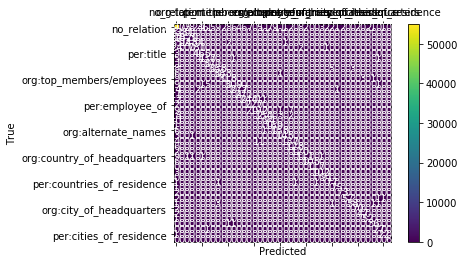

Accuracy: 0.9901649932476073
Precision: 0.960453595640052
Recall: 0.9579131670648836
F1 score: 0.9587989365147751


In [25]:
    plot_comfusion_matrix(label_types, predict_types, output_path, "train_full")

In [26]:
    # testing data analysis
    tacred_reader = DataLoader(test_path, e_label2idx, r_label2idx, d_label2idx, config.dep_sz, {"lower": True})
    # AllenNLP DatasetReader
    reader = RelationDatasetReader(
        is_training=True, 
        reader=tacred_reader, 
        tokenizer=lambda s: token_indexer.wordpiece_tokenizer(s),
        token_indexers={"tokens": token_indexer}
    )
    
    test_ds = reader.read(test_path)
    print(len(test_ds))
    seq_iterator = BasicIterator(batch_size=config.batch_size)
    seq_iterator.index_with(vocab)
    
    predictor = Predictor(model, seq_iterator, cuda_device=0 if USE_GPU else -1)
    test_preds = predictor.predict(test_ds) 
    
    label_types = [r_idx2label.get(i.fields['label'].label) for i in test_ds]
    predict_types = [r_idx2label.get(i) for i in np.argmax(test_preds, axis=-1)]  
    
    err_analyze(test_ds, label_types, predict_types, "test")
#     pre = np.array([r_label2idx[i] for i in predict_types])
#     lab = np.array([r_label2idx[i] for i in label_types])
#     compute_macro_PRF(pre, lab)

100%|██████████| 15509/15509 [00:30<00:00, 508.45it/s]
15509it [00:11, 1330.41it/s]
  0%|          | 2/1551 [00:00<01:34, 16.36it/s]

15509


100%|██████████| 1551/1551 [00:47<00:00, 30.60it/s]


[[11521    75    52 ...     2     1     0]
 [  136   364     0 ...     0     0     0]
 [  130     0   170 ...     0     0     0]
 ...
 [    3     0     0 ...     2     0     0]
 [    2     0     0 ...     0     0     0]
 [    4     0     0 ...     2     0     0]]


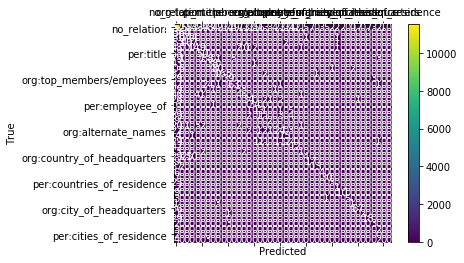

Accuracy: 0.8462828035334322
Precision: 0.5153369958323547
Recall: 0.37690180327775086
F1 score: 0.41625372258601123


In [27]:
    plot_comfusion_matrix(label_types, predict_types, output_path, "test_full")